# TODO:
1. Представити початковi данi графiчно.

2. Розбити данi на навчальний та валiдацiйний набори.

3. Побудувати на навчальному наборi даних моделi регресiї.

4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).

5. Виконати прогнози на основi побудованих моделей.

6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.

10. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

• коефiцiєнт детермiнацiї R2,
• помилки RMSE, MAE та MAPE.

11. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.

12. Зробити висновки про якiсть роботи моделей на дослiджених даних. На основi критерiїв якостi спробувати обрати найкращу модель.

13. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки розмiр навчальної множини впливає на якiсть моделi.

14. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за наведеними вище етапами. Можна обрати власний набiр даних (повiдомивши попередньо про це викладача), наприклад, з цiкавої вам практичної задачi. Для кожного набору спробувати пiдiбрати найкращу модель.

TODO-spec:
3. Побудувати модель регресiї, використовуючи sklearn.neural_network.MLPRegressor

Початковi данi:
(а) sklearn.datasets.load_diabetes
(б) www.kaggle.com/htagholdings/property-sales

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score as R2, mean_squared_error as MSE, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from math import ceil
from sklearn.compose import TransformedTargetRegressor

Визначимо функцію, для обчислення основних метрик оцінки регресії:

In [2]:
def metrics_calc(y_true: np.array, y_predict: np.array):
    """Функція для зручного обчислення метрик регресії"""
    metrics = {
        "r2": R2(y_true, y_predict),
        "rmse": np.sqrt(MSE(y_true, y_predict)),
        "mae": MAE(y_true, y_predict),
        "mape": MAPE(y_true, y_predict)}
    return metrics

In [3]:
# Завантажуємо набори даних
ds_1 = load_diabetes(as_frame = True).frame
ds_2 = pd.read_csv('./raw_sales.csv')

In [4]:
ds_1 # Огляд першого датасету

age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  target  
0   -0.002592  0.019907 -0.017646   151.0  
1   -0.039493 -0.068332 -0.092204    75.0  
2   -0.002592  0.002861 -0.025930   141.0  
3    0.034309  0.022688 -0.009362   206.0  
4   -0.002592 -0.031988 -0.046641   135.0  
..        ...       ...       ...     ...  
437 -0.002592  0.031193  0.007207   178.0  
438  0.034309 -0.018114  0.044485   104.0  
439 -0.011080 -0.046883  0.015491   132.0  
440  0.026560  0.044529 -0.025930   220.0  
441 -0.039493 -0.004222  0.003064    57.0  

[442 rows x 11 columns]

Маємо 11 ознак. Ознаки `age`, `sex`, `bmi` відповідають за вік, стать і індекс маси тіла, але мають значення у проміжку (-.2, .2), очевидно, це попередньо оброблені дані. Цільова змінна, скоріше за все, відповідає за ймовірність виявлення діабету, або значення рівня цукру для пацієнта.

Дані вже готові до роботи

In [5]:
ds_2 # Огляд другого датасету

datesold  postcode   price propertyType  bedrooms
0      2007-02-07 00:00:00      2607  525000        house         4
1      2007-02-27 00:00:00      2906  290000        house         3
2      2007-03-07 00:00:00      2905  328000        house         3
3      2007-03-09 00:00:00      2905  380000        house         4
4      2007-03-21 00:00:00      2906  310000        house         3
...                    ...       ...     ...          ...       ...
29575  2019-07-25 00:00:00      2900  500000         unit         3
29576  2019-07-25 00:00:00      2612  560000         unit         2
29577  2019-07-26 00:00:00      2912  464950         unit         2
29578  2019-07-26 00:00:00      2601  589000         unit         2
29579  2019-07-26 00:00:00      2612  775000         unit         2

[29580 rows x 5 columns]

Маємо 5 ознак. `datesold` - день продажі, `postcode` - поштовий індекс, `propertyType` - приватний будинок або ж квартира, `bedrooms` - кількість кімнат. Цільова змінна вказує за яку ціну було продано нерухомість.

Поштовий індекс є не вагомим при визначенні ціни нерухомості, цю ознаку можна прибрати. Тип нерухомості приведемо до значень True/False. Дату продажі розіб'ємо на рік, місяць і день.

In [6]:
ds_2.drop(columns = ["postcode"], inplace =True) # Поштовий індекс не є вагомим, тому видаляємо його як зайву інформацію

# Переводимо дату в формат datetime і розбиваємо на місяці дні тижня
ds_2["datesold"] = pd.to_datetime(ds_2["datesold"])
ds_2['day'] = ds_2["datesold"].dt.day
ds_2["month"] = ds_2["datesold"].dt.month
ds_2['year'] = ds_2['datesold'].dt.year

# Змінюємо значення propertyType на True(unit)/False(house)
ds_2["propertyType"] = pd.get_dummies(ds_2["propertyType"], drop_first = True)

# Видаляємо початковий стовбець з часом продажу
ds_2.drop(columns = ["datesold"], inplace = True)

In [7]:
ds_2 # Тепер можна подивитись на оновлений датасет

price  propertyType  bedrooms  day  month  year
0      525000         False         4    7      2  2007
1      290000         False         3   27      2  2007
2      328000         False         3    7      3  2007
3      380000         False         4    9      3  2007
4      310000         False         3   21      3  2007
...       ...           ...       ...  ...    ...   ...
29575  500000          True         3   25      7  2019
29576  560000          True         2   25      7  2019
29577  464950          True         2   26      7  2019
29578  589000          True         2   26      7  2019
29579  775000          True         2   26      7  2019

[29580 rows x 6 columns]

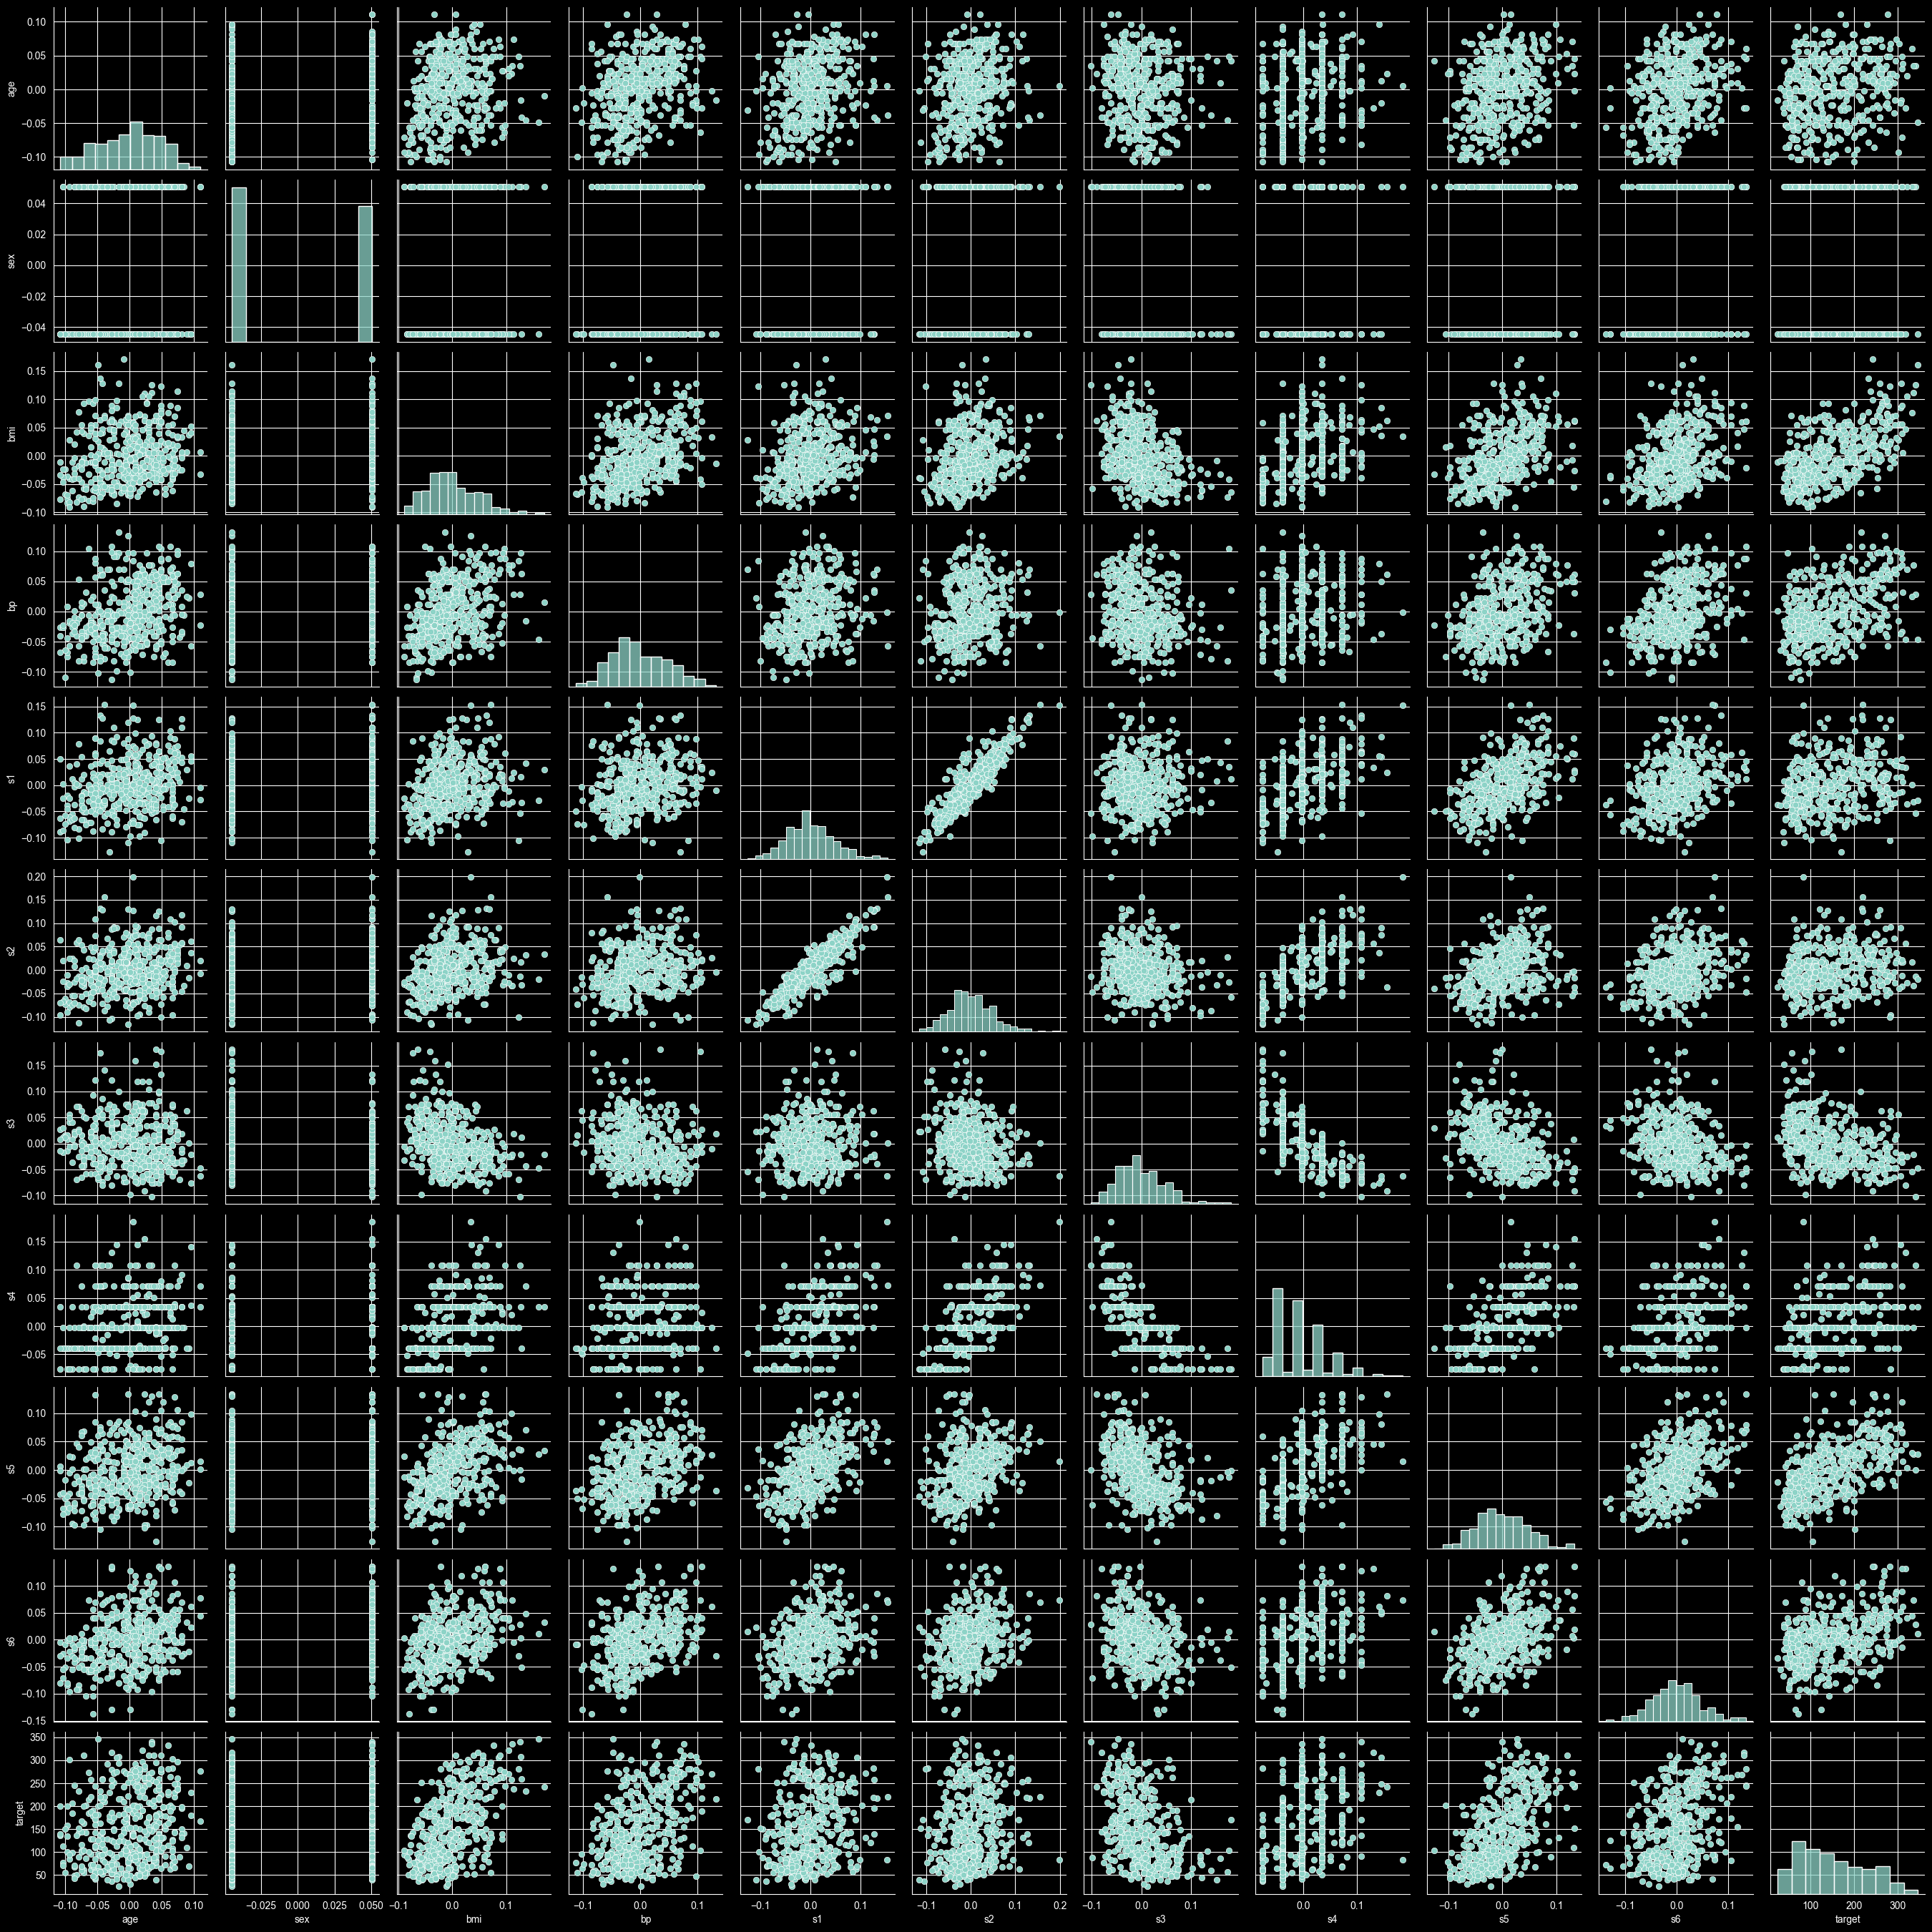

In [8]:
sns.pairplot(ds_1); # Поглянемо на розподіл ознак відносно один одної у першому датасеті

Попередньо бачимо, що найбільший вплив на значення цільової змінної мають ознаки `bmi`, `s4`, `s5`, `s6`. Менший, але значущий, вплив мають `bp`, `s2`, `s3`.


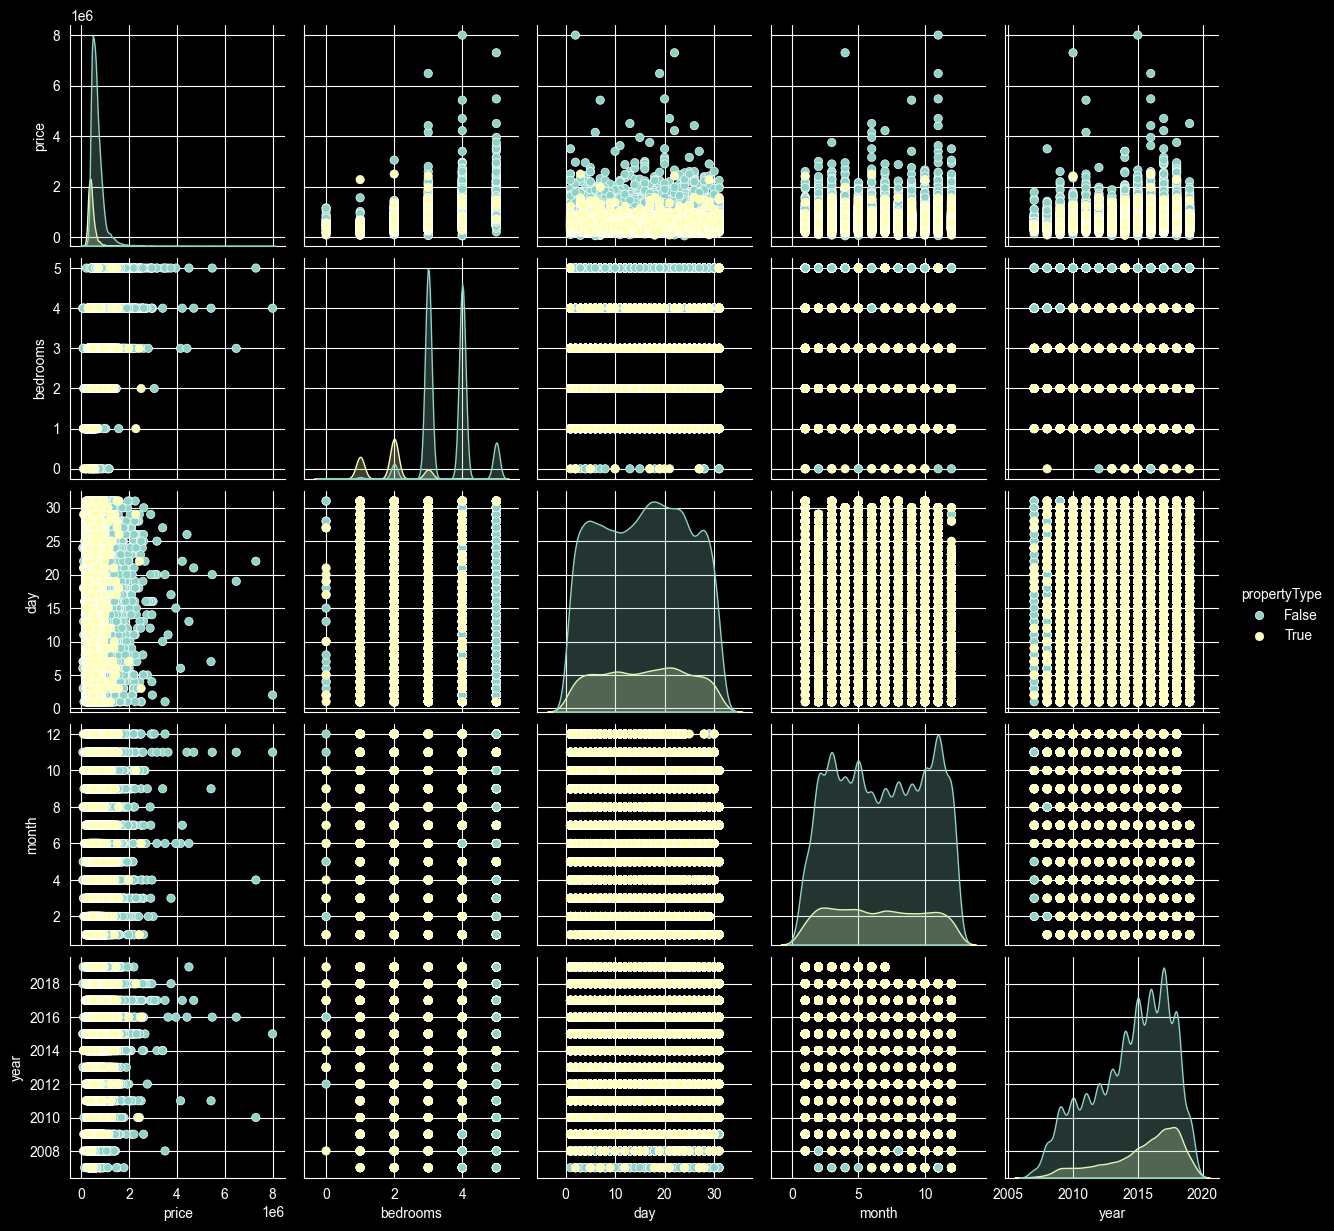

In [9]:
sns.pairplot(ds_2, hue = 'propertyType'); # Поглянемо на розподіл ознак відносно один одної у другому датасеті

Очікувано, на вартість нерухомості впливає рік продажі `year` і більшим чином кількість кімнат `bedrooms`.

Для навчання нейронних мереж ітеративно розбиватимемо набір на навчальний і тестовий в різних пропорціях - починаючи від 20% тренувального набору до 80%. Також ітеративно будемо додавати кількість нейронів до мережі й тренувати її, зберігаючи результати у DataFrame `results`.

In [54]:
# Створюємо порожній DataFrame для зберігання майбутніх результатів
results = pd.DataFrame(columns = ['architecture', 'train_size',"ds", 'r2', 'rmse', 'mae', 'mape', 'test_super_metric', 'train_super_metric'])

for train_size in np.linspace(0.2, 0.8, 5):  # Робимо цикл по розміру навчального набору

    # Розбиваємо індекси ds_1 та ds_2 у пропорції поточної ітерації циклу
    train_ds_1, test_ds_1 = train_test_split(np.arange(0, len(ds_1)), test_size=1 - train_size, random_state=42)
    train_ds_2, test_ds_2 = train_test_split(np.arange(0, len(ds_2)), test_size=1 - train_size, random_state=42)

    # За розбитими індексами розбиваємо самі набори даних. Для зручності зберігаємо їх у словнику
    dss = {
        "ds_1":{"X_train": ds_1.loc[train_ds_1].drop(columns =["target"]), "y_train": ds_1.loc[train_ds_1, ["target"]],
                "X_test": ds_1.loc[test_ds_1].drop(columns =["target"]), "y_test": ds_1.loc[test_ds_1, ["target"]], },
        "ds_2": {"X_train":ds_2.loc[train_ds_2].drop(columns =["price"]), "y_train": ds_2.loc[train_ds_2, ["price"]],
                 "X_test": ds_2.loc[test_ds_2].drop(columns =["price"]), "y_test": ds_2.loc[test_ds_2, ["price"]]}
    }

    for ds in dss: # Цикл для ітерації по обох датасетах

        for arch in [1, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
            model = MLPRegressor(hidden_layer_sizes=arch,
                     activation='relu',
                     solver='adam',
                     learning_rate_init=1e-3,
                     max_iter=2000,
                     early_stopping=True,
                     n_iter_no_change=20,
                     tol=1e-4,
                     random_state=42,
                     verbose=False)


            ds_X_train = dss[ds]["X_train"]
            ds_y_train = dss[ds]["y_train"]
            ds_X_test = dss[ds]["X_test"]
            ds_y_test = dss[ds]["y_test"]

            ds_y_train = np.ravel(ds_y_train)
            ds_y_test = np.ravel(ds_y_test)

            scaler = StandardScaler()
            ds_X_train = scaler.fit_transform(ds_X_train)
            ds_X_test = scaler.transform(ds_X_test)

            base_mlp = MLPRegressor(
                hidden_layer_sizes=arch,
                activation='relu',
                solver='adam',
                alpha=1e-6,                # важливо!
                learning_rate_init=0.005,  # важливо!
                max_iter=5000,
                early_stopping=False,      # для стабільності
                random_state=42,
                verbose=False
            )

            model = TransformedTargetRegressor(
            regressor=base_mlp,
            transformer=StandardScaler()
            )
            # Навчаємо модель на навчальних даних
            model.fit(ds_X_train, ds_y_train)

            # Перевіряємо модель на навчальній множині та зберігаємо результат
            y_pred = model.predict(ds_X_train)
            new_row = pd.DataFrame.from_dict(metrics_calc(ds_y_train, y_pred), orient = "index").T
            # Додаємо нову метрику, за якою оцінюватимемо якість моделі, як середнє зважене чотирьох базових метрик.
            # При r2 відʼємний коефіцієнт, тому що на відміну від mae, mape і т.д., які ми намагаємося мінімізувати, r2 ми намагаємося максимізувати. Отже, коефіцієнти при r2 та інших метриках має бути різними
            train_super_metric = (new_row['r2']  * -100 + new_row['mape'] * 100) + new_row['rmse'] + new_row['mae']

            # Перевіряємо модель на тестувальній множині та зберігаємо результат
            y_pred = model.predict(ds_X_test)
            new_row = pd.DataFrame.from_dict(metrics_calc(ds_y_test, y_pred), orient = "index").T
            new_row['train_super_metric'] = train_super_metric
            new_row['test_super_metric'] = (new_row['r2']  * -100 + new_row['mape'] * 100) + new_row['rmse'] + new_row['mae']
            new_row["ds"] = ds
            new_row['train_size'] = train_size
            new_row['architecture'] = arch
            new_row['model'] = model
            results = pd.concat([results, new_row], ignore_index=True)

In [55]:
idx = results.groupby(['ds']) # Вибираємо значення для тестових даних і групуємо
results

architecture  train_size    ds        r2           rmse            mae  \
0             1         0.2  ds_1  0.192475      69.420659      58.527424   
1             5         0.2  ds_1  0.307318      64.295103      51.409957   
2            10         0.2  ds_1 -0.040801      78.812424      61.010839   
3            20         0.2  ds_1 -0.035864      78.625304      62.533376   
4            50         0.2  ds_1  0.006654      76.994771      60.146851   
..          ...         ...   ...       ...            ...            ...   
95          100         0.8  ds_2  0.318769  214550.462746  141136.555118   
96          200         0.8  ds_2  0.320510  214276.126005  141859.875794   
97          300         0.8  ds_2  0.320081  214343.762336  140983.181348   
98          400         0.8  ds_2  0.322202  214009.290670  137907.716931   
99          500         0.8  ds_2  0.305564  216619.886378  144979.071709   

        mape  test_super_metric  train_super_metric  \
0   0.528276         161.528170          166.981811   
1   0.418339         126.807212           35.226598   
2   0.496329         193.536246          -31.694780   
3   0.489894         193.734568          -81.043513   
4   0.492762         185.752423          -82.767153   
..       ...                ...                 ...   
95  0.231820      355678.322952       383943.666301   
96  0.235654      356127.516162       384861.576931   
97  0.232434      355318.178917       384020.134410   
98  0.222624      351907.049830       380465.655789   
99  0.237239      361592.125530       388435.932207   

                                                model  
0   TransformedTargetRegressor(regressor=MLPRegres...  
1   TransformedTargetRegressor(regressor=MLPRegres...  
2   TransformedTargetRegressor(regressor=MLPRegres...  
3   TransformedTargetRegressor(regressor=MLPRegres...  
4   TransformedTargetRegressor(regressor=MLPRegres...  
..                                                ...  
95  TransformedTargetRegressor(regressor=MLPRegres...  
96  TransformedTargetRegressor(regressor=MLPRegres...  
97  TransformedTargetRegressor(regressor=MLPRegres...  
98  TransformedTargetRegressor(regressor=MLPRegres...  
99  TransformedTargetRegressor(regressor=MLPRegres...  

[100 rows x 10 columns]

Маємо набір результатів. Подивимось на найкращі з них.

In [56]:
best_of_the_best = idx['test_super_metric'].min(numeric_only=True)
best_of_the_best

ds
ds_1        82.915188
ds_2    351522.914881
Name: test_super_metric, dtype: float64

In [57]:
new_results = results[(results['test_super_metric'] == best_of_the_best['ds_1']) | (results['test_super_metric'] == best_of_the_best['ds_2'])]
new_results

architecture  train_size    ds        r2           rmse            mae  \
61            5        0.65  ds_1  0.502865      53.456326      43.145571   
75          100        0.65  ds_2  0.321859  215520.112283  136013.502322   

        mape  test_super_metric  train_super_metric  \
61  0.365998          82.915188           75.625969   
75  0.214862      351522.914881       384680.331825   

                                                model  
61  TransformedTargetRegressor(regressor=MLPRegres...  
75  TransformedTargetRegressor(regressor=MLPRegres...

"Супер" метрика, яка є середнім зваженим більш типових метрик (r2, rmse, mae, mape), яку необхідно було мінімізувати показує, що:

  - Результати для першого набору даних поступаються результатам регресійних моделей, побудованих у минулій лабораторній на 9,4%. Крім того, бачимо, що найкраща модель для цього набору була навчена на максимально великому тренувальному наборі - 80% усього датасету, що є більш природнім показником, ніж 65% для регресійних моделей з минулої лабораторної.
  - Результати для другого набору даних поступаються звичайним регресіям лише на 0,3%

Перевіримо чи має місце перенавчання


In [58]:
new_results['Abs_difference_super_metrics'] = (new_results['test_super_metric'] - new_results['train_super_metric']) / new_results['train_super_metric']
new_results[['architecture', 'ds', 'Abs_difference_super_metrics']]

architecture    ds  Abs_difference_super_metrics
61            5  ds_1                      0.096385
75          100  ds_2                     -0.086195

Бачимо, що для першого датасету модель показує себе набагато краще на навчальному наборі, ніж на тестовому. Маємо перенавчання. Це також підтверджується тим, що була обрана архітектура з 400 нейронами, очевидно, що модель з 500 нейронами ще більше перенавчена і показує ще гірші результати на тестовому наборі.
Для другого датасету маємо кращі результати на тестовому наборі ніж на тренувальному, що може свідчити про недонавчання.

In [59]:
def plot_predictions(ds: pd.DataFrame, model, target: 'str', ds_name: 'str', n_cols=3):

    X = ds.drop(columns=[target])
    y_true = ds[target]
    y_pred = model.predict(X).flatten()

    num_features = X.shape[1]
    n_rows = ceil(num_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(X.columns):
        ax = axes[i]
        sns.scatterplot(x=X[feature], y=y_true, label='Actual', alpha=0.6, ax=ax)
        sns.scatterplot(x=X[feature], y=y_pred, label='Predicted', alpha=0.6, ax=ax)
        ax.set_title(f"{feature}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Target")
        ax.legend()

    # Ховаємо зайві subplot-и
    for j in range(num_features, len(axes)):
        axes[j].set_visible(False)
    fig.suptitle(f'{ds_name}, {model}', fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

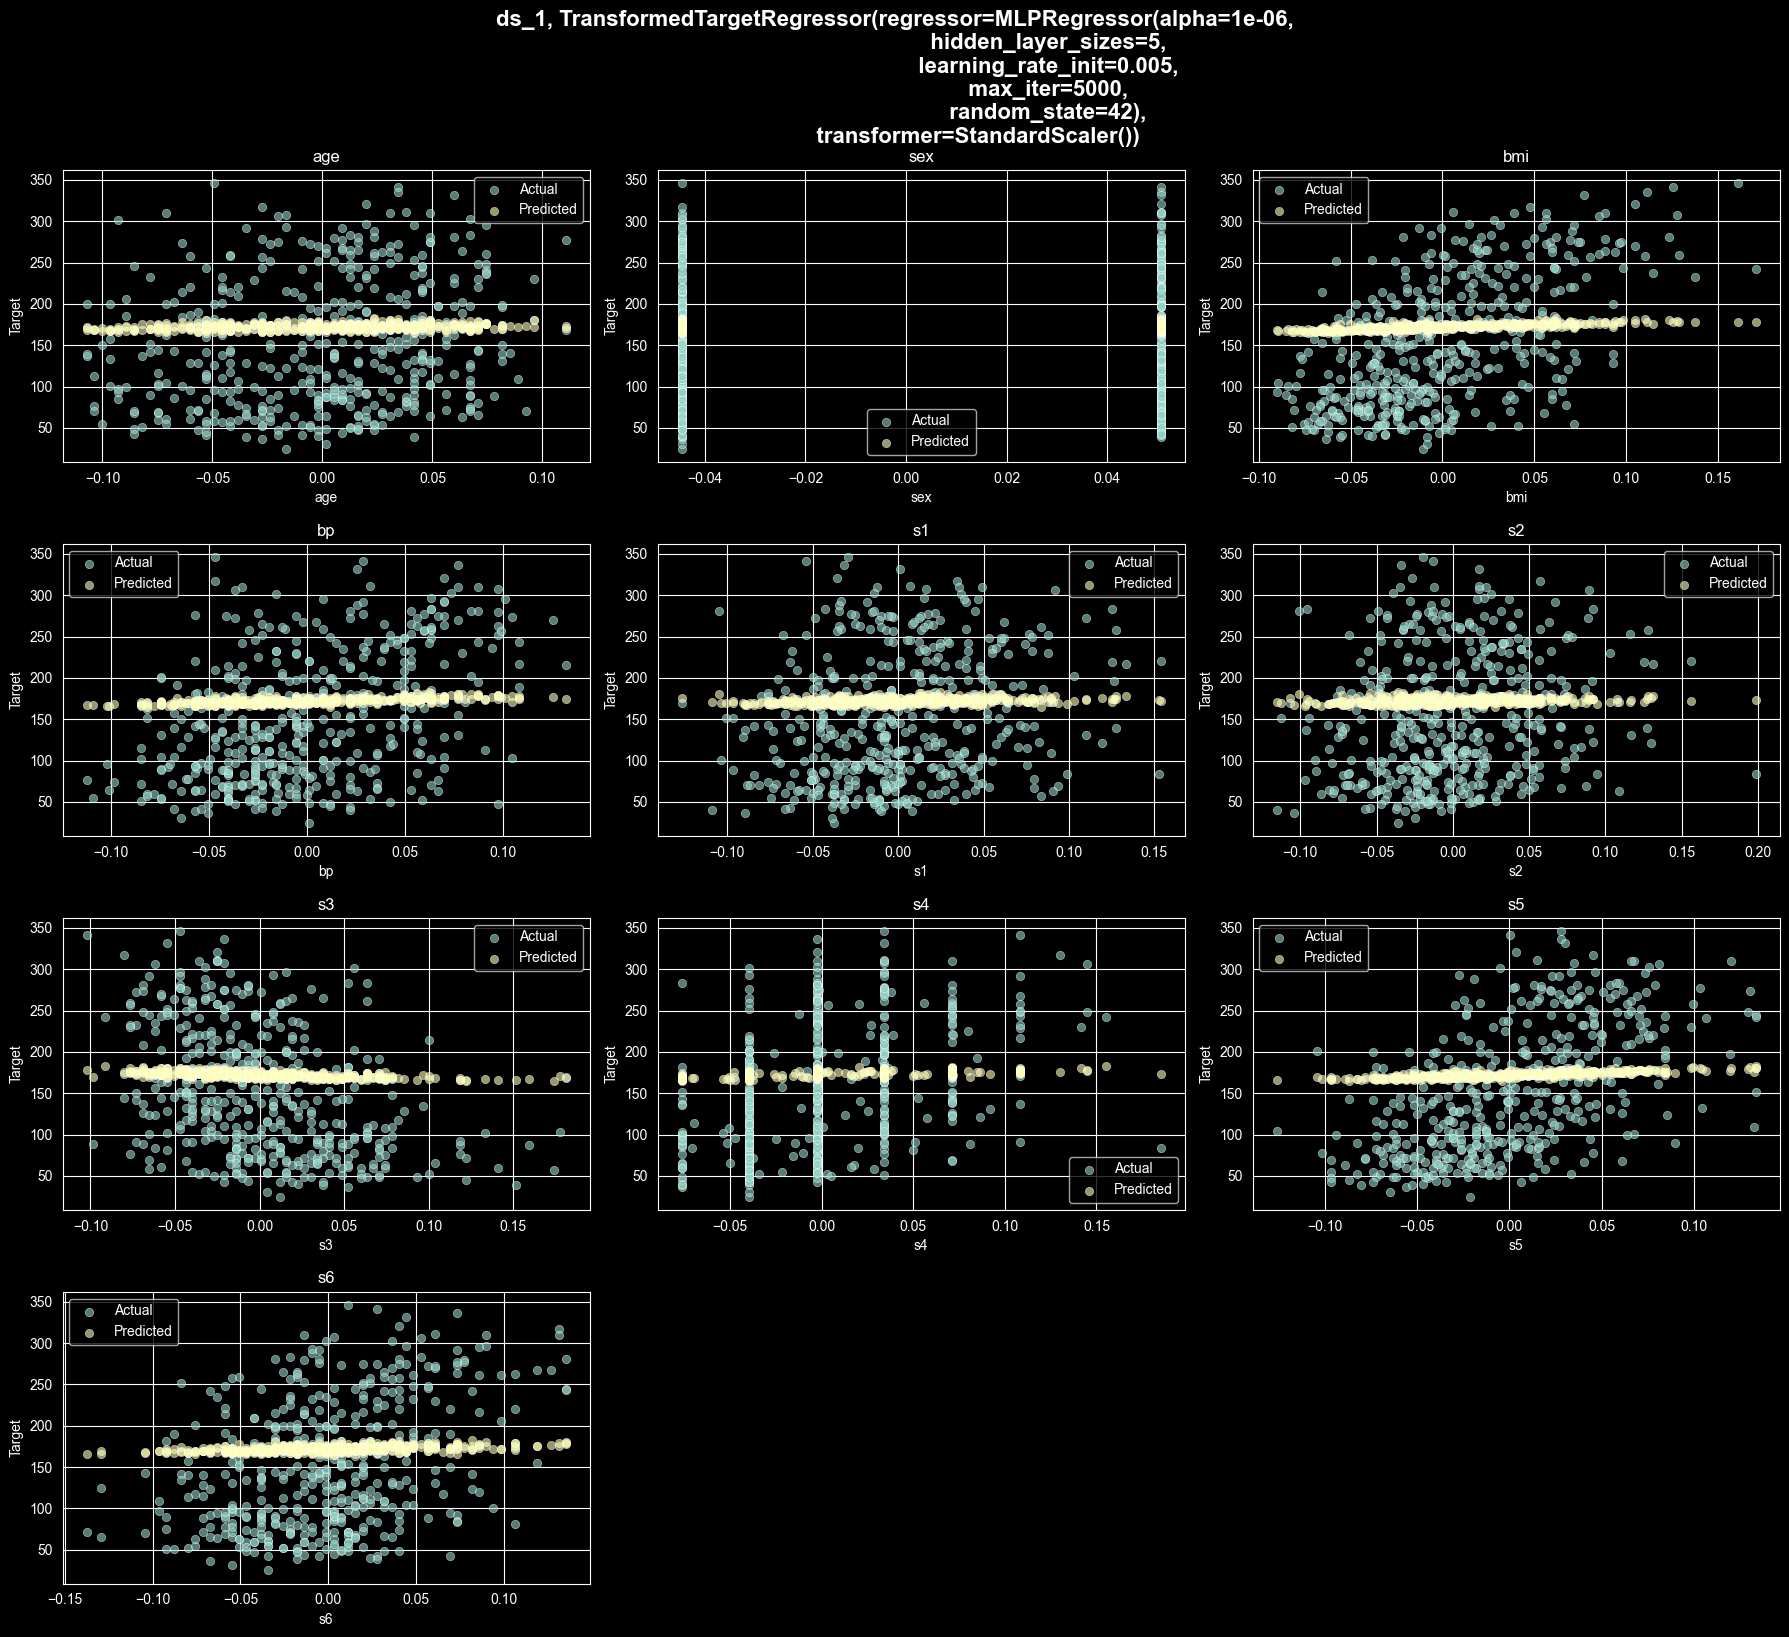

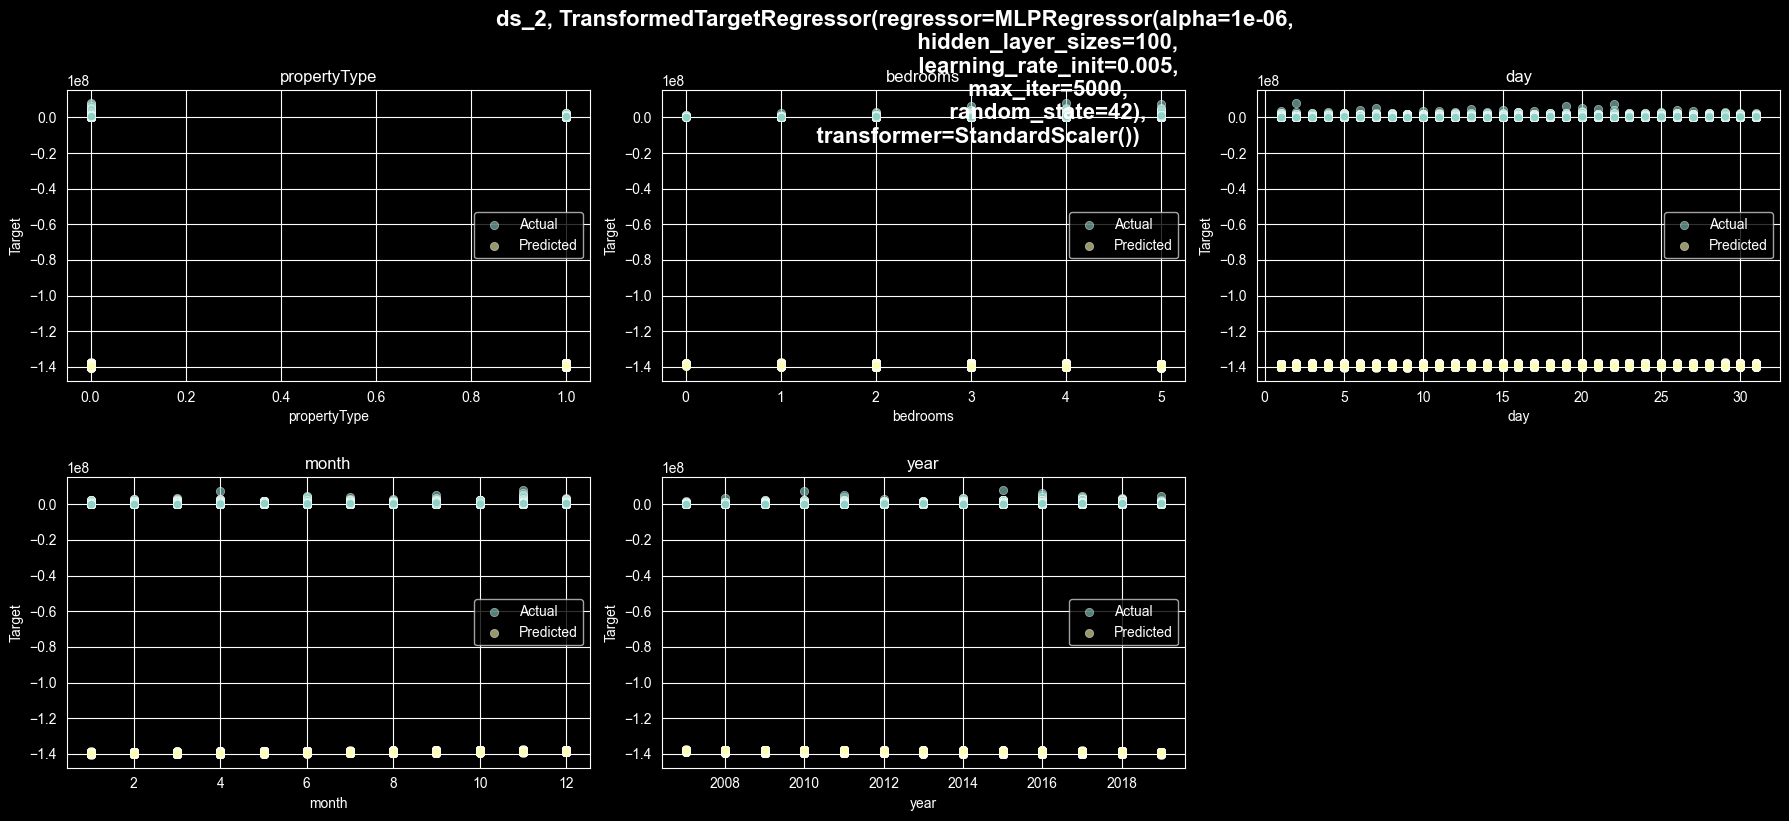

In [60]:
for model in new_results[new_results['ds'] == 'ds_1']['model']:
    plot_predictions(ds_1, model, 'target', ds_name='ds_1')

for model in new_results[new_results['ds'] == 'ds_2']['model']:
    plot_predictions(ds_2, model, 'price', ds_name='ds_2')

Тепер побудуємо дво- і тришарові мережі. Одношарові моделі показали себе найкраще на максимальному розмірі навчального набору, тому багатошарові мережі навчатимемо лише на 80% даних.

In [61]:
# Створюємо порожній DataFrame для зберігання майбутніх результатів
multilayer_results = pd.DataFrame(columns=['architecture', "ds", 'r2', 'rmse', 'mae', 'mape', 'test_super_metric', 'train_super_metric'])

# Розбиваємо індекси ds_1 та ds_2 на навчальну і тестову множину
train_ds_1, test_ds_1 = train_test_split(np.arange(0, len(ds_1)), test_size=0.2, random_state=42)
train_ds_2, test_ds_2 = train_test_split(np.arange(0, len(ds_2)), test_size=0.2, random_state=42)

# За розбитими індексами розбиваємо самі набори даних. Для зручності зберігаємо їх у словнику
dss = {
    "ds_1": {"X_train": ds_1.loc[train_ds_1].drop(columns=["target"]), "y_train": ds_1.loc[train_ds_1, ["target"]],
             "X_test": ds_1.loc[test_ds_1].drop(columns=["target"]), "y_test": ds_1.loc[test_ds_1, ["target"]], },
    "ds_2": {"X_train": ds_2.loc[train_ds_2].drop(columns=["price"]), "y_train": ds_2.loc[train_ds_2, ["price"]],
             "X_test": ds_2.loc[test_ds_2].drop(columns=["price"]), "y_test": ds_2.loc[test_ds_2, ["price"]]}
}

for ds in dss:  # Цикл для ітерації по обох датасетах

    for arch in [(100, 50), (200, 100), (300, 100), (200, 100, 50), (300, 150, 75)]:
        ds_X_train = dss[ds]["X_train"]
        ds_y_train = dss[ds]["y_train"]
        ds_X_test = dss[ds]["X_test"]
        ds_y_test = dss[ds]["y_test"]

        ds_y_train = np.ravel(ds_y_train)
        ds_y_test = np.ravel(ds_y_test)

        scaler = StandardScaler()
        ds_X_train = scaler.fit_transform(ds_X_train)
        ds_X_test = scaler.transform(ds_X_test)

        base_mlp = MLPRegressor(
            hidden_layer_sizes=arch,
            activation='relu',
            solver='adam',
            alpha=1e-6,
            learning_rate_init=0.005,
            max_iter=5000,
            early_stopping=False,
            random_state=42,
            verbose=False
        )

        model = TransformedTargetRegressor(
            regressor=base_mlp,
            transformer=StandardScaler()
        )

        # Навчаємо модель на навчальних даних
        model.fit(ds_X_train, ds_y_train)

        # Перевіряємо модель на навчальній множині та зберігаємо результат
        y_pred = model.predict(ds_X_train)
        new_row = pd.DataFrame.from_dict(metrics_calc(ds_y_train, y_pred), orient="index").T
        # Додаємо нову метрику, за якою оцінюватимемо якість моделі, як середнє зважене чотирьох базових метрик.
        # При r2 відʼємний коефіцієнт, тому що на відміну від mae, mape і т.д., які ми намагаємося мінімізувати, r2 ми намагаємося максимізувати. Отже, коефіцієнти при r2 та інших метриках має бути різними
        train_super_metric = (new_row['r2'] * -100 + new_row['mape'] * 100) + new_row['rmse'] + new_row['mae']

        # Перевіряємо модель на тестувальній множині та зберігаємо результат
        y_pred = model.predict(ds_X_test)
        new_row = pd.DataFrame.from_dict(metrics_calc(ds_y_test, y_pred), orient="index").T
        new_row['train_super_metric'] = train_super_metric
        new_row['test_super_metric'] = (new_row['r2'] * -100 + new_row['mape'] * 100) + new_row['rmse'] + new_row['mae']
        new_row["ds"] = ds
        new_row['architecture'] = [arch]
        new_row['model'] = model
        multilayer_results = pd.concat([results, new_row], ignore_index=True)


In [62]:
idx = multilayer_results.groupby(['ds'])
best_of_the_best = idx['test_super_metric'].min(numeric_only=True)
multilayer_new_results = multilayer_results[(multilayer_results['test_super_metric'] == best_of_the_best['ds_1']) | (multilayer_results['test_super_metric'] == best_of_the_best['ds_2'])]
multilayer_new_results

architecture  train_size    ds        r2           rmse            mae  \
61            5        0.65  ds_1  0.502865      53.456326      43.145571   
75          100        0.65  ds_2  0.321859  215520.112283  136013.502322   

        mape  test_super_metric  train_super_metric  \
61  0.365998          82.915188           75.625969   
75  0.214862      351522.914881       384680.331825   

                                                model  
61  TransformedTargetRegressor(regressor=MLPRegres...  
75  TransformedTargetRegressor(regressor=MLPRegres...

In [63]:
multilayer_new_results['Abs_difference_super_metrics'] = (multilayer_new_results['test_super_metric'] - multilayer_new_results['train_super_metric']) / multilayer_new_results['train_super_metric']
multilayer_new_results[['architecture', 'ds', 'Abs_difference_super_metrics']]

architecture    ds  Abs_difference_super_metrics
61            5  ds_1                      0.096385
75          100  ds_2                     -0.086195

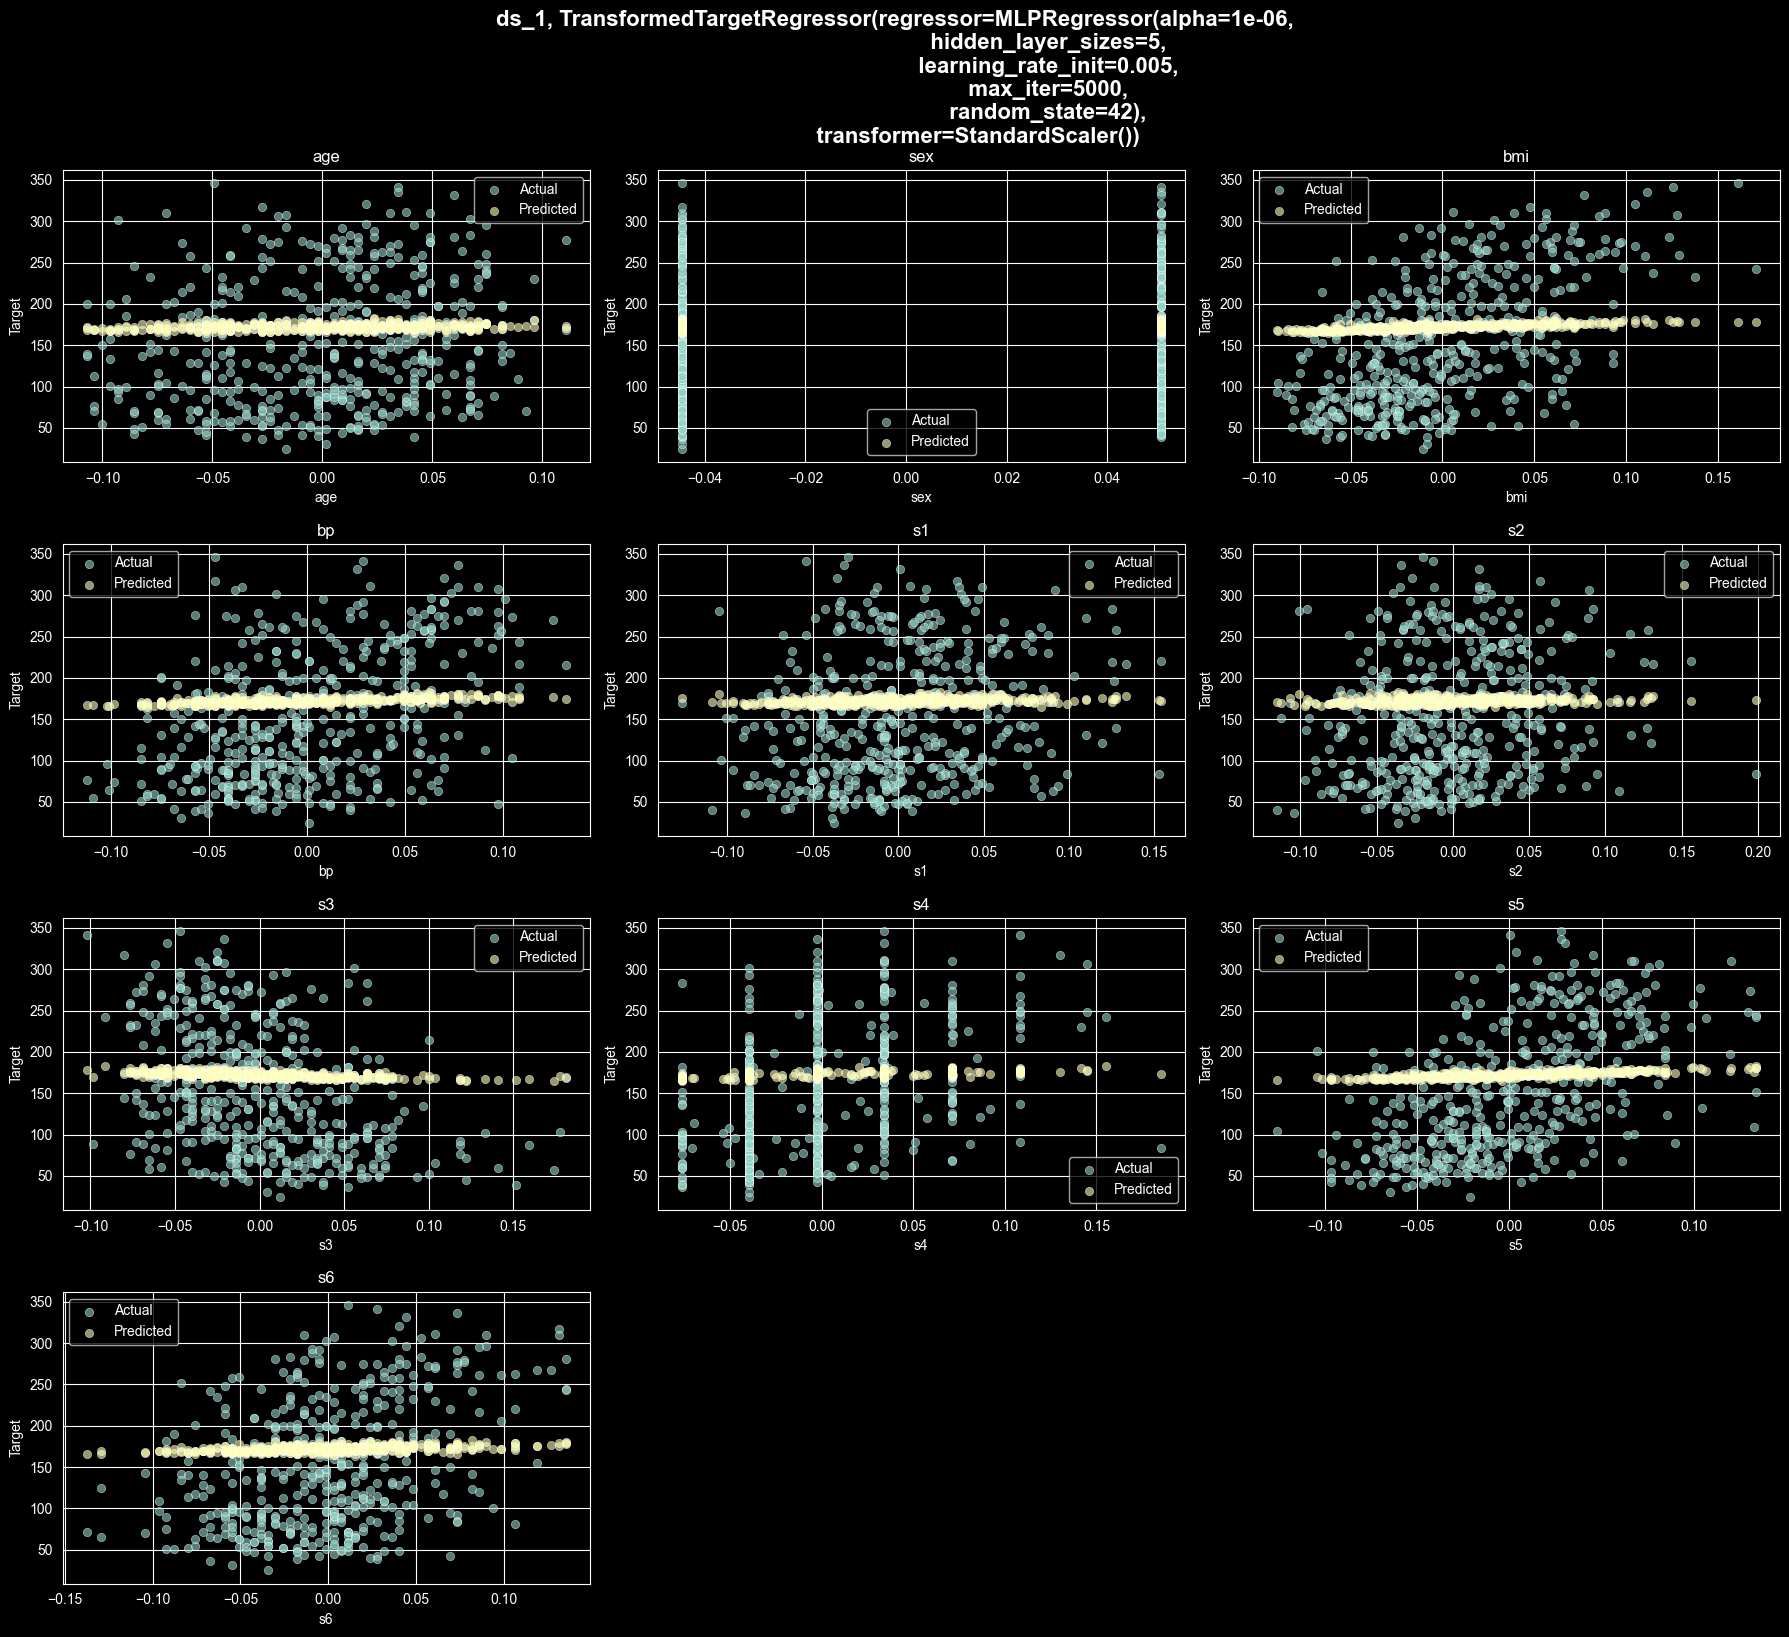

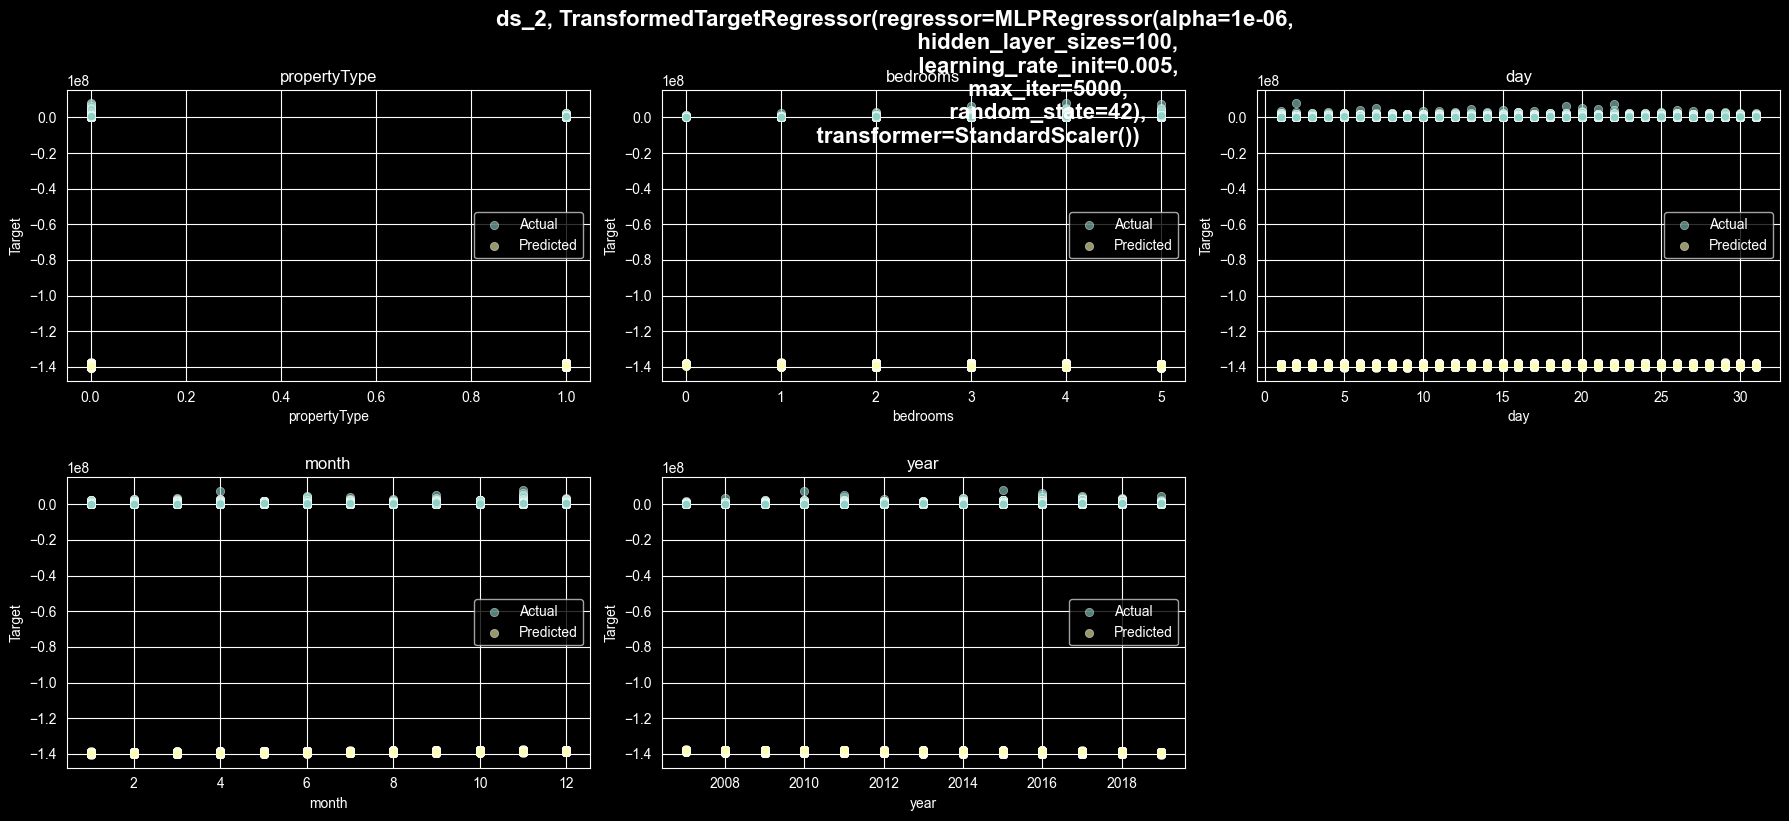

In [64]:
for model in multilayer_new_results[multilayer_new_results['ds'] == 'ds_1']['model']:
    plot_predictions(ds_1, model, 'target', ds_name='ds_1')

for model in multilayer_new_results[multilayer_new_results['ds'] == 'ds_2']['model']:
    plot_predictions(ds_2, model, 'price', ds_name='ds_2')

Висновки:
  В ході виконання роботи ми побудували декілька одношарових перцептронів з різною кількістю схованих ознак. Можемо побачити на метриках, що кількість схованих ознак дуже чутливий параметр і його збільшення покращує результати.